In [1]:
import dtale
import chess
import chess.pgn
import chess.svg

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
df = pd.read_csv("games.csv")

In [3]:
# Filtering

# These are ids of illegal games that must be removed (e.g. checkmated with King).
illegal_ids = ['8BsfZrzx', 'jX4zmQIo']

df0 = df[df["rated"]==True].reset_index().drop(columns=["index","rated","white_id","black_id"])
df1 = df0.drop(index=np.where(np.isin(df0["id"],illegal_ids))[0])

In [4]:
df1.head()

,id,created_at,last_move_at,turns,victory_status,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,l1NXvwaE,1.504130e+12,1.504130e+12,16,resign,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
1,mIICvQHh,1.504130e+12,1.504130e+12,61,mate,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
2,kWKvrqYL,1.504110e+12,1.504110e+12,61,mate,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
3,9tXo1AUZ,1.504030e+12,1.504030e+12,95,mate,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
4,qwU9rasv,1.504230e+12,1.504230e+12,33,resign,white,10+0,1520,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10


In [5]:
df1.columns

Index(['id', 'created_at', 'last_move_at', 'turns', 'victory_status', 'winner',
       'increment_code', 'white_rating', 'black_rating', 'moves',
       'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [6]:
# Defines dict to map notation of pieces to their respective string representation
pieces_san_dict = {"p":"Pawn","N":"Knight","B":"Bishop","R":"Rook","Q":"Queen","K":"King"}

# Define function that returns which piece delivered mate, by parsing the moves column.
def mate_piece(move_list):
    last_move = move_list[-1]
    if "#" in last_move:
        #consider that pawns don't have uppecase lettering. 
        if last_move[0].isupper():
            return pieces_san_dict[last_move[0]]
        else:
            return 'Pawn'
    else:
        return None


In [7]:
%%time

## Program to derive useful info from the 'moves' column.
## Parse the moves column into a list of "fens" which are strings that represent the board, the pieces on the board, and their coordinates
fens = []
mate_pieces_list = []
for game in df1["moves"]:
    move_list = game.split() # prep move_list
    
    board = chess.Board() # Initialize board
    for move in move_list:
        board.push(board.parse_san(move)) # plays the game to reach final position
    
    fens.append(board.fen())
    mate_pieces_list.append(mate_piece(move_list)) # uses mate piece function to find what piece checkmated.
    
## Takes about 40 seconds on my end.
## Append these columns to the dataframe. 
df1["endFEN"] = fens
df1["mated_by"] = mate_pieces_list

CPU times: user 18.8 s, sys: 75.1 ms, total: 18.9 s
Wall time: 18.9 s


In [10]:
# Code in this cell is adapted from https://andreasstckl.medium.com/chessviz-graphs-of-chess-games-7ebd4f85a9b9
# Define a function that coverts the FEN notation into a tensor representation of the board.

def fen_to_tensor(input_str):
    # creates a dictionary of pieces. 1 to 6 is white pieces, -1 to -6 is black pieces.
    pieces_str = "PNBRQKpnbrqk"
    pieces = set(pieces_str)
    pieces_dict = {pieces_str[0]:1, pieces_str[1]:2, pieces_str[2]:3, pieces_str[3]:4 , 
                    pieces_str[4]:5, pieces_str[5]:6,
                    pieces_str[6]:-1, pieces_str[7]:-2, pieces_str[8]:-3, pieces_str[9]:-4, 
                    pieces_str[10]:-5, pieces_str[11]:-6}
    
    # creates a tensor representation of the board. 
    # This tensor represents a 8*8 board for each of the 6 possible pieces.
    # The first two axis are the coordinates, the third axis is whether there is a piece there or not.
    # If 1, there is a white piece there. If -1, there is a black piece there.
    # For example, if the value at position (0,0,0) is 1, then there is a white pawn at the A8 sqr.
    board_tensor = np.zeros((8,8,6))
    input_list = input_str.split()
    rownr = 0
    colnr = 0
    valid_spaces = set(range(1,9))
    
    # As input list is a split FEN, index 0 is the pos of each piece on the board.
    # This loop goes through every element of the FEN which is the same as looking at each square of the board in sequence and seeing what piece is there.
    for i,c in enumerate(input_list[0]):
        if c in pieces:
            board_tensor[rownr,colnr,np.abs(pieces_dict[c])-1] = np.sign(pieces_dict[c])
            colnr = colnr + 1
        elif c == "/": 
            #a backslash means the row is over, so we go to the next row
            rownr += 1
            colnr = 0
        elif int(c) in valid_spaces:
            # a number means that many squares in the row are empty.
            colnr += int(c)
        else:
            raise ValueError("invalid fenstr at index: {} char: {}".format(i, c))
        
    return board_tensor
    
    
# Define other useful functions for these tensors.
# Counts the total amount of pieces on the board.
def count_pieces(fen):
    board_tensor = fen_to_tensor(fen)
    return np.sum(np.abs(board_tensor))

# This outputs a tuple containing the total amt of pawns, knights, bishops, rooks, and queens in the board.
def count_all_pieces(fen):
    board_tensor = fen_to_tensor(fen)
    counts = np.sum(np.abs(board_tensor),axis=(0,1))
    return counts[0],counts[1],counts[2],counts[3],counts[4]

# This outputs both King's square position
def king_squares(fen):
    board_tensor = fen_to_tensor(fen)
    king_col,king_row=np.where(board_tensor[:,:,5]==1)
    white_king_coordinates = king_col[0],king_row[0]
    king_col,king_row=np.where(board_tensor[:,:,5]==-1)
    black_king_coordinates = king_col[0],king_row[0]
    
    return white_king_coordinates,black_king_coordinates

# Define function that outputs the type of ending.
# Common endings in chess include Pawn endings, Rook endings, 
def is_pawn_ending(fen):
    board_tensor = fen_to_tensor(fen)
    # the counts function will count occupied squares for any given "piece" matrix.
    # e.g., counts[0] will return the amount of pawns. 
    counts = np.sum(np.abs(board_tensor),axis = (0,1))
    if counts[1]==0 and counts[2]==0 and counts[3]==0 and counts[4]==0:
        return True
    else:
        return False
    


In [11]:
# Just a test cell to test the understanding of this technique.
fen = chess.Board().fen()
test_fen = fens[0]
# check for pawn at B7, king in E8, king in E1
coords = [(1,1,0),(0,4,5),(7,4,5)] 
for coord in coords:
    print(fen_to_tensor(test_fen)[coord])

-1.0
-1.0
1.0


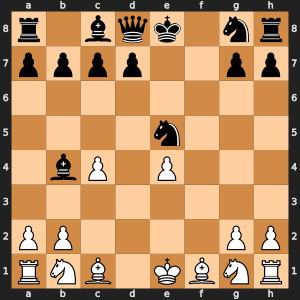

In [12]:
board = chess.Board(test_fen)
chess.svg.board(board,size=300)

In [24]:
## Now let's use the FENS and functions we have to derive more columns.

# Total amount of pieces on the board.
df1["nr_of_pieces"] = df1["endFEN"].apply(count_pieces)

# gets the nr of each piece on the board
temp = df1["endFEN"].apply(count_all_pieces)
for i,piece in enumerate(["pawns","knights","bishops","rooks","queens"]):
    df1[piece] = temp.apply(lambda x:x[i])
# This might not be very useful because it doesn't discern between white and black pieces, but that is okay for now. 
# It can be used for filters based on presence of pieces at endgame.
# We can use the number of pieces and turns to define arbitrarily if the game ended in the opening, midgame, or endgame.

# Defines columns for both kings positions
temp = df1["endFEN"].apply(king_squares)
for i,sqr in enumerate(["wKing_sqr","bKing_sqr"]):
    df1[sqr] = temp.apply(lambda x:x[i])
    

In [12]:
# In this cell, define how to construct info for the chess board heatmap. 


# e.g. creating 16 columns, one for each piece. Value is its coordinate

# Or 64 coordinates, where the value is what piece is present there.

# If plotly had a way to decode tensors into locations, this would be very easy, I imagine.

### Dataset Export

In [26]:
# Export the preprocessed dataset.
df_export = df1.copy()
df_export.to_csv("chess_app.csv")